Projet Python 2025

In [47]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("alertes_enrichies.csv")
df.tail(5) # 5 derniers enregistrements (les plus récents)

,Titre Alerte,Type,Description,Lien,Date,CVE ID,Description CVE,CWE,Nature de la faille,Score CVSS,Gravité CVSS,Score EPSS,Gravité EPSS,Éditeur,Produit,Versions Affectées
35,Multiples vulnérabilités dans le noyau Linux d...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2024-49935,"In the Linux kernel, the following vulnerabili...",Non disponible,Non disponible,NaN,Non disponible,0.00017,Faible,Linux,Linux,2.6.32
36,Multiples vulnérabilités dans le noyau Linux d...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2024-53093,"In the Linux kernel, the following vulnerabili...",Non disponible,Non disponible,NaN,Non disponible,0.00014,Faible,Linux,Linux,4.15
37,Multiples vulnérabilités dans les produits IBM...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-36000,IBM WebSphere Application Server Liberty 17.0....,CWE-79,CWE-79 Improper Neutralization of Input During...,4.4,Moyenne,0.00015,Faible,IBM,WebSphere Application Server Liberty,17.0.0.3
38,Vulnérabilité dans Microsoft Edge (09 janvier ...,Avis,Une vulnérabilité a été découverte dans Micros...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-62224,User interface (ui) misrepresentation of criti...,CWE-451,CWE-451: User Interface (UI) Misrepresentation...,5.5,Moyenne,0.00062,Faible,Microsoft,Microsoft Edge for Android,1.0.0
39,Multiples vulnérabilités dans les produits Mic...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-11964,"On Windows only, if libpcap needs to convert a...",CWE-787,CWE-787 Out-of-bounds Write,1.9,Faible,0.00015,Faible,The Tcpdump Group,libpcap,1.10.0


Etape 5 : Interprétation et visualisation

Lien entre les scores CVSS et EPSS

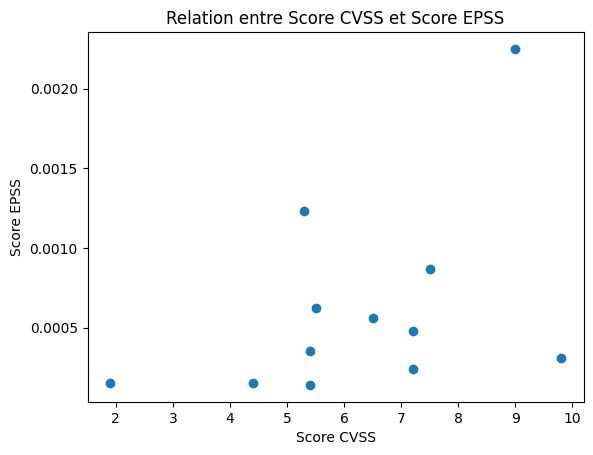

In [48]:
plt.plot(df['Score CVSS'], df['Score EPSS'], "o")
plt.title('Relation entre Score CVSS et Score EPSS')
plt.xlabel('Score CVSS')
plt.ylabel('Score EPSS')
plt.show()